In [1]:
import os
import time
import random
import xml.etree.ElementTree as ET

import cv2
import numpy as np

import torch

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

import matplotlib.pyplot as plt

## Hyper-Params & Utils

In [2]:
WIDER_CLASSES = ('__background__', 'face')

batch_size = 16

In [3]:
class AnnotationTransform(object):
    def __init__(self, class_to_ind=None, keep_difficult=True, norm=True):
        self.class_to_ind = class_to_ind or dict(
            zip(WIDER_CLASSES, range(len(WIDER_CLASSES))))
        self.keep_difficult = keep_difficult
        self.norm = norm

    def __call__(self, target):
        res = np.empty((0, 15))

        size = target.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        for obj in target.iter('object'):
            difficult = int(obj.find('difficult').text) == 1
            if not self.keep_difficult and difficult:
                continue
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            # has_lm = int(obj.find('has_lm').text)

            # get face rect
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            bndbox = []
            for i, pt in enumerate(pts):
                cur_pt = int(bbox.find(pt).text)
                bndbox.append(cur_pt)

            # get face landmark
            if int(obj.find('has_lm').text.strip()) == 1:
                lm = obj.find('lm')
                pts = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5']
                for i, pt in enumerate(pts):
                    xy_value = float(lm.find(pt).text)
                    bndbox.append(xy_value)
            else:  # append 10 zeros
                for i in range(10):
                    bndbox.append(0)

            # normalize xy
            if self.norm:
                bndbox = [coord/width if idx%2==0 else coord/height for idx,coord in enumerate(bndbox)]
            
            # label 0 or 1 (bk or face)
            label_idx = self.class_to_ind[name]
            bndbox.append(label_idx)

            res = np.vstack(
                (res, bndbox))  # [xmin, ymin, xmax, ymax, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, w, h, label_ind]
        return res

In [4]:
def denorm(coords, shape):
    coords[:, 0::2] = coords[:, 0::2] * shape[0]
    coords[:, 1::2] = coords[:, 1::2] * shape[1]

In [5]:
def draw(img: np.ndarray, bboxes: np.ndarray, landmarks: np.ndarray=None, scores: np.ndarray=None) -> np.ndarray:
    '''
    This function draws bounding boxes and landmarks on the image and return the result.
    
    Parameters:
        bboxes    - bboxes of shape [n, 5]. 'n' for number of bboxes, '5' for coordinate and confidence 
                    (x1, y1, x2, y2, c).
        landmarks - landmarks of shape [n, 5, 2]. 'n' for number of bboxes, '5' for 5 landmarks
                    (two for eyes center, one for nose tip, two for mouth corners), '2' for coordinate
                    on the image.
    Returns:
        img       - image with bounding boxes and landmarks drawn
    '''

    # convert BGR to RGB for correct color display
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # draw bounding boxes
    if bboxes is not None:
        color = (0, 255, 0)
        thickness = 2
        for idx in range(bboxes.shape[0]):
            bbox = bboxes[idx].astype(np.int)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
            if scores:
                cv2.putText(img, '{:.4f}'.format(scores[idx]), (bbox[0], bbox[1]+12), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # draw landmarks
    if landmarks is not None:
        radius = 2
        thickness = 2
        color = [(255, 0, 0), (0, 0, 255), (0, 255, 255), (255, 255, 0), (0, 255, 0)]
        for idx in range(landmarks.shape[0]):
            face_landmarks = landmarks[idx].astype(np.int)
            for idx, landmark in enumerate(face_landmarks):
                cv2.circle(img, (int(landmark[0]), int(landmark[1])), radius, color[idx], thickness)
    return img

# Official DALI

## Defining the data source

In [6]:
class WIDERFaceIterator(object):
    def __init__(self, root_dir, anno_transformer=AnnotationTransform(), batch_size=16):
        self.root = root_dir
        self.anno_transformer = anno_transformer
        self.batch_size = batch_size
        
        self.ids = list()
        with open(os.path.join(self.root, 'img_list.wf.txt'), 'r') as f:
            self.ids = [tuple(line.split()) for line in f]

    def __len__(self):
        return len(self.ids)
            
    def __iter__(self):
        self.i = 0
        self.n = len(self.ids)
        return self

    def __next__(self):
        img = list()
        bbox = list()
        lm = list()
        label = list()
        for _ in range(self.batch_size):
            jpg_filename, anno_filename = self.ids[self.i]

            # read images
            jpg_fhandler = open(os.path.join(self.root, jpg_filename), 'rb')
            img.append(
                np.frombuffer(jpg_fhandler.read(), dtype=np.uint8)
            )

            # read ground truths (bbox+landmark) and cls
            anno = self.anno_transformer(
                ET.parse(os.path.join(self.root, anno_filename)).getroot()
            )
            bbox.append(
                np.ascontiguousarray(anno[:, :4], dtype=np.float32)
            )
            lm.append(
                np.ascontiguousarray(anno[:, 4:-1], dtype=np.float32)
            )
            label.append(
                np.ascontiguousarray(anno[:, -1], dtype=np.int32)
            )

            self.i = (self.i + 1) % self.n
        return (img, bbox, lm, label)

## RandomBBoxCrop Pipeline

In [7]:
# define the pipeline
class CropPipeline(Pipeline):
    def __init__(self, source_iterator, batch_size=16, num_threads=2, device_id=0):
        super(CropPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.source = ops.ExternalSource(source=source_iterator, num_outputs=4)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        # Data augmentation
        self.crop = ops.RandomBBoxCrop(
            device="cpu",
            aspect_ratio=[0.5, 2.0],
            scaling=[0.3, 1.0],
            thresholds=[1.0],
            threshold_type='overlap',
            all_boxes_above_threshold=False,
            bbox_layout="xyXY",
            allow_no_crop=True,
            num_attempts=1,
            total_num_attempts=250
        )
        self.slice = ops.Slice(device='cpu')
        
    def define_graph(self):
        jpgs, bboxes, lms, labels = self.source()
        imgs = self.decode(jpgs)

        crop_begin, crop_size, bboxes_, labels_ = self.crop(bboxes, labels)
        imgs_ = self.slice(imgs, crop_begin, crop_size)

        return (imgs_, bboxes_, labels_, imgs, bboxes, lms, labels)

## Test

In [8]:
# use the pipeline
wfi = WIDERFaceIterator('./WIDER_FACE_rect')
pipe = CropPipeline(wfi)
pipe.build()
start = time.time()
pipe_out = pipe.run()
end = time.time()
print(end-start)

0.2221996784210205


In [9]:
cropped_img = pipe_out[0]
cropped_bbx = pipe_out[1]
cropped_label = pipe_out[2]

ori_img = pipe_out[3]
ori_bbx = pipe_out[4]
ori_lm  = pipe_out[5]
ori_label = pipe_out[6]

(40, 4)
(1024, 683)
(40, 4)
(683, 1024, 3)


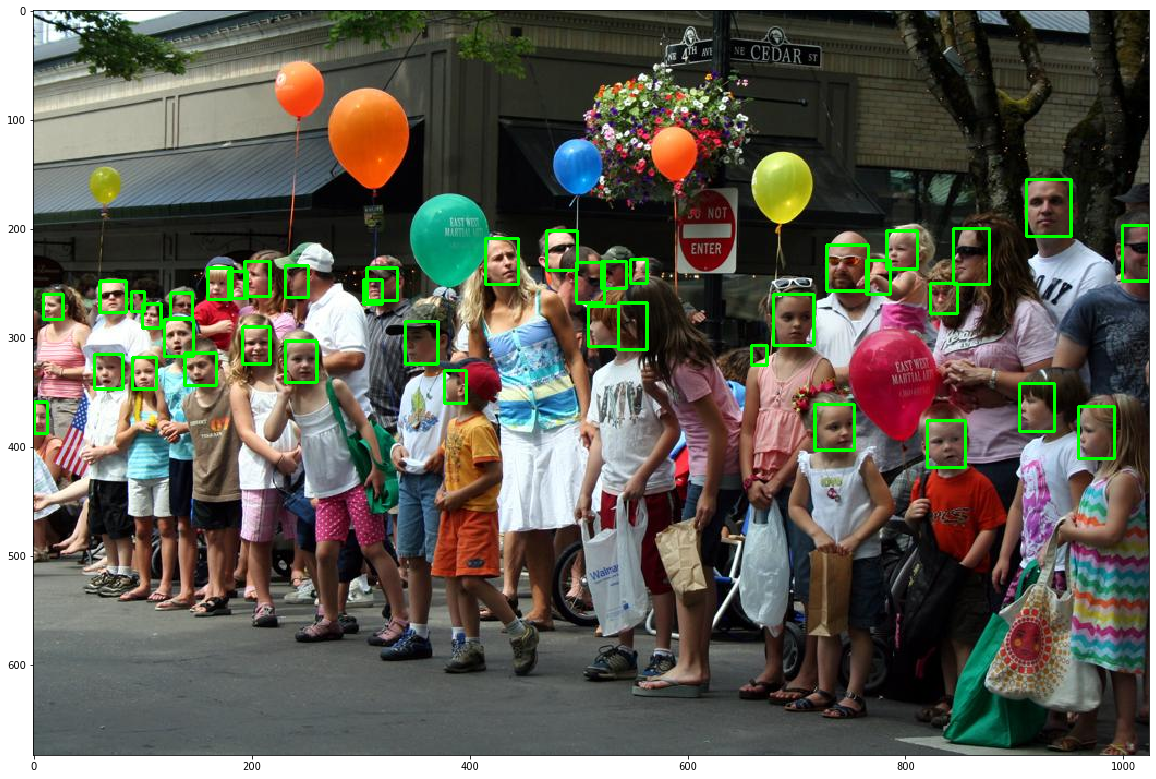

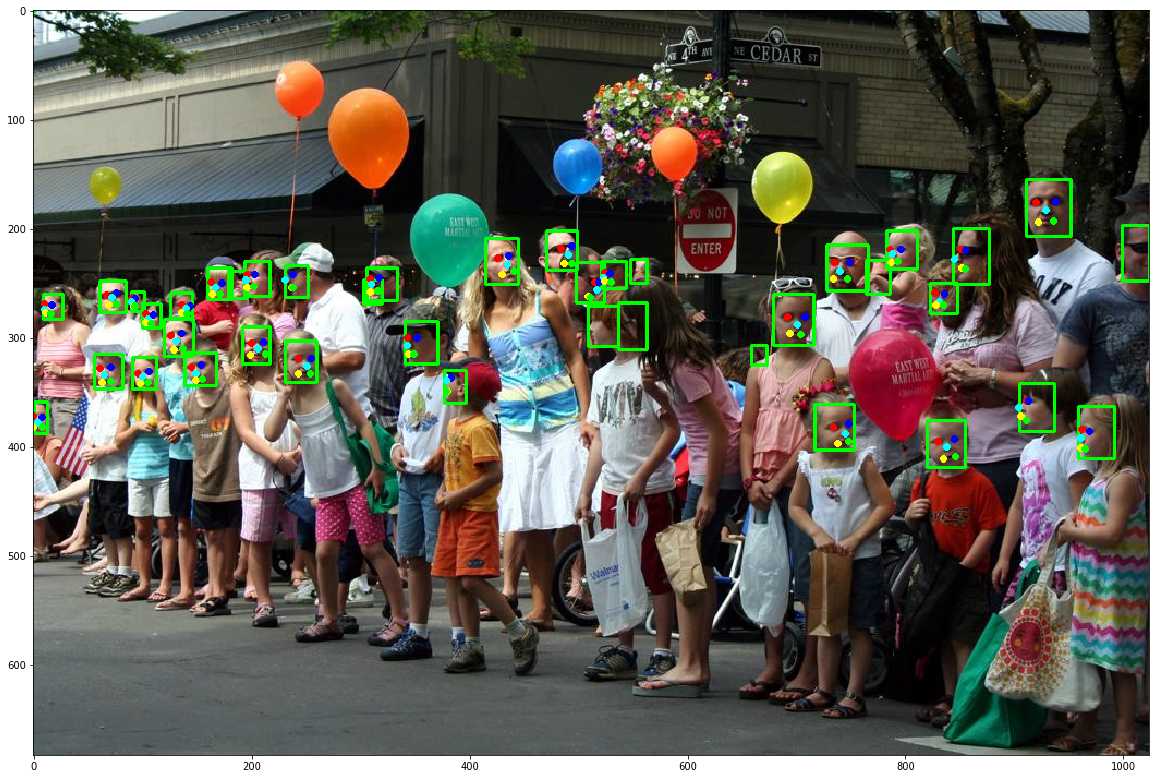

In [10]:
idx = random.randrange(batch_size)

cimg = cropped_img.at(idx)
cbbx = cropped_bbx.at(idx)
clabel = cropped_label.at(idx)
denorm(cbbx, (cimg.shape[1], cimg.shape[0]))
print(cbbx.shape)
print((cimg.shape[1], cimg.shape[0]))
plt.figure(figsize = (20,14))
plt.imshow(draw(cimg, cbbx))

oimg = ori_img.at(idx)
obbx = ori_bbx.at(idx)
olm = ori_lm.at(idx)
olabel = ori_label.at(idx)
denorm(obbx, (oimg.shape[1], oimg.shape[0]))
denorm(olm, (oimg.shape[1], oimg.shape[0]))
print(obbx.shape)
print(oimg.shape)
plt.figure(figsize = (20,14))
plt.imshow(draw(oimg, obbx, np.reshape(olm, (-1, 5, 2))))


## DALI plugin - My Impl

In [11]:
import nvidia.dali.plugin_manager as plugin_manager
plugin_manager.load_library('/home/tau/projects/DALI_plugins/build/libExtendRandomBBoxCrop.so')

In [12]:
class MyCropPipeline(Pipeline):
    def __init__(self, source_iterator, batch_size=16, num_threads=2, device_id=0):
        super(MyCropPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.source = ops.ExternalSource(source=source_iterator, num_outputs=4)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        # Data augmentation
        self.crop = ops.ExtendRandomBBoxCrop(
            device="cpu",
            aspect_ratio=[0.5, 2.0],
            scaling=[0.3, 1.0],
            thresholds=[1.0],
            threshold_type='overlap',
            all_boxes_above_threshold=False,
            bbox_layout="xyXY",
            allow_no_crop=True,
            num_attempts=1,
            total_num_attempts=250
        )
        self.slice = ops.Slice(device='cpu')
        
    def define_graph(self):
        jpgs, bboxes, lms, labels = self.source()
        imgs = self.decode(jpgs)

        crop_begin, crop_size, bboxes_, lms_, labels_ = self.crop(bboxes, lms, labels)
        imgs_ = self.slice(imgs, crop_begin, crop_size)

        return (imgs_, bboxes_, lms_, labels_, imgs, bboxes, lms, labels)

## Test

In [13]:
# use the pipeline
wfi1 = WIDERFaceIterator('./WIDER_FACE_rect')
mypipe = MyCropPipeline(wfi1)
mypipe.build()
start = time.time()
mypipe_out = mypipe.run()
end = time.time()
print(end-start)

0.22803330421447754


In [14]:
print(len(mypipe_out))
cropped_img = mypipe_out[0]
cropped_bbx = mypipe_out[1]
cropped_lms = mypipe_out[2]
cropped_label = mypipe_out[3]

ori_img = mypipe_out[4]
ori_bbx = mypipe_out[5]
ori_lm  = mypipe_out[6]
ori_label = mypipe_out[7]

8


(4, 4)
(989, 592)
(19, 4)
(807, 1024, 3)


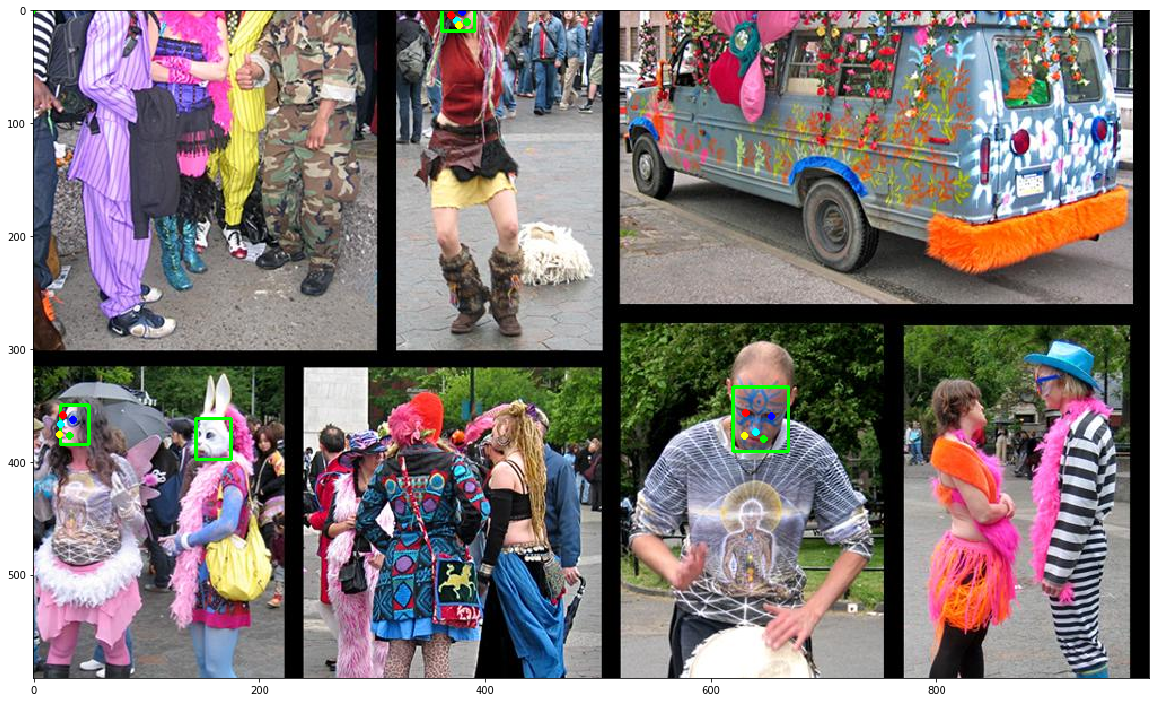

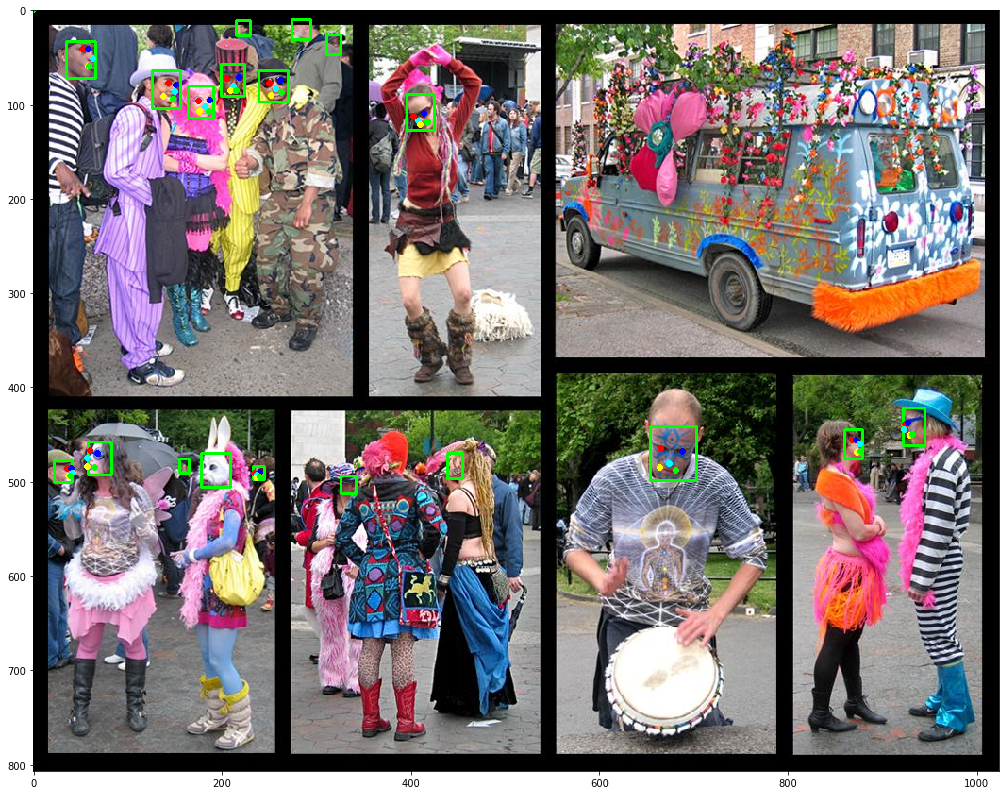

In [16]:
idx = random.randrange(batch_size)

cimg = cropped_img.at(idx)
cbbx = cropped_bbx.at(idx)
clms = cropped_lms.at(idx)
clabel = cropped_label.at(idx)
denorm(cbbx, (cimg.shape[1], cimg.shape[0]))
denorm(clms, (cimg.shape[1], cimg.shape[0]))
print(cbbx.shape)
print((cimg.shape[1], cimg.shape[0]))
plt.figure(figsize = (20,14))
plt.imshow(draw(cimg, cbbx, np.reshape(clms, (-1, 5, 2))))

oimg = ori_img.at(idx)
obbx = ori_bbx.at(idx)
olm = ori_lm.at(idx)
olabel = ori_label.at(idx)
denorm(obbx, (oimg.shape[1], oimg.shape[0]))
denorm(olm, (oimg.shape[1], oimg.shape[0]))
print(obbx.shape)
print(oimg.shape)
plt.figure(figsize = (20,14))
plt.imshow(draw(oimg, obbx, np.reshape(olm, (-1, 5, 2))))